<a href="https://colab.research.google.com/github/9645258/aiffel/blob/main/02_goingdeeper/01_nlp/%5BGD-02%5Dnlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GD NLP 02 : 멋진 단어사전 만들기**

소설책 1권 분량의 텍스트를 lecture에서 다룬 다양한 기법으로 전처리하여 단어사전을 만들어 본다. 각각의 단어사전을 토대로 language model을 생성하여 perplexity를 측정해 보고 어떤 기법의 성능이 우수한지 평가해 본다. 

- **SentencePiece 사용하기**  
    - SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?  
    - SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?  
    - SentencePiece의 성능을 다각도로 비교분석하였는가?  


---

# **1. 데이터 준비**

## **1-1. 라이브러리 Import**

In [ ]:
import os
import csv
import konlpy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sentencepiece as spm

from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

## **1-2. 데이터 Import**

In [ ]:
train_data = pd.read_table('C:/Users/96452/00_work/NLP-02/data/ratings_train.txt')
test_data = pd.read_table('C:/Users/96452/00_work/NLP-02/data/ratings_test.txt')

## **1-3. 데이터 형태 확인**

### **1-3-1. train_data 데이터 형태 확인**

**데이터 수**  
총 15,000개
    
**컬럼 수**  
총 3개 (id, document, label)  

In [ ]:
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


### **1-3-2. test_data 데이터 형태 확인**

**데이터 수**  
총 5,000개
    
**컬럼 수**  
총 3개 (id, document, label)  

In [ ]:
test_data

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


---

# **2. 전처리 진행**

## **2-1. 결측치 및 중복 데이터 제거**

### **2-1-1. 결측치 및 중복 데이터 확인 함수**

In [ ]:
def data_info(data):
    print("데이터 수:", len(data))
    print("중복 데이터 수:", data.isnull().sum())
    print("null 값:", len(data)-len(set(data)))

### **2-1-2. train_data 결측치 및 중복 데이터 확인**

In [ ]:
data_info(train_data["document"])

데이터 수: 150000
중복 데이터 수: 5
null 값: 3817


### **2-1-3. train_data 결측치 및 중복 데이터 제거**

In [ ]:
train_data.dropna(inplace=True)
train_data.drop_duplicates(["document"], inplace=True)

In [ ]:
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


### **2-1-4. test_data 결측치 및 중복 데이터 확인**

In [ ]:
data_info(test_data["document"])

데이터 수: 50000
중복 데이터 수: 3
null 값: 842


### **2-1-5. test_data 결측치 및 중복 데이터 제거**

In [ ]:
test_data.dropna(inplace=True)
test_data.drop_duplicates(["document"], inplace=True)

In [ ]:
test_data

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


## **2-2. 데이터 분포 길이 조정**

### **2-2-1. 데이터 분포 길이 확인 및 시각화 함수**

In [ ]:
def draw_sentence_length(data, title):
    min_len = 999
    max_len = 0
    sum_len = 0
    
    data = data.dropna()
    cleaned_corpus = list(set(data))
    
    for sen in cleaned_corpus:
        length = len(sen)
        if min_len > length: min_len = length
        if max_len < length: max_len = length
        sum_len += length
        
    sentence_length = np.zeros((max_len), dtype=np.int)

    for sen in cleaned_corpus:
        sentence_length[len(sen)-1] += 1

    plt.bar(range(max_len), sentence_length, width=1.0)
    plt.title(title)
    plt.show()
    
    print("전체 문장 수:", len(cleaned_corpus))
    print("최단 문장 길이:", min_len)
    print("최장 문장 길이:", max_len)
    print("평균 문장 길이:", sum_len // len(cleaned_corpus))

### **2-2-2. train_data 데이터 분포 길이 확인 및 시각화**

C:\Users\96452\AppData\Local\Temp\ipykernel_13424\324541869.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


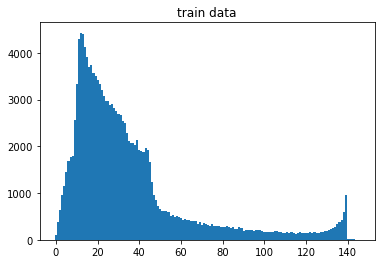

전체 문장 수: 146182
최단 문장 길이: 1
최장 문장 길이: 146
평균 문장 길이: 35


In [ ]:
draw_sentence_length(train_data["document"], title = "train data")

### **2-2-2. test_data 데이터 분포 길이 확인 및 시각화**

C:\Users\96452\AppData\Local\Temp\ipykernel_13424\324541869.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


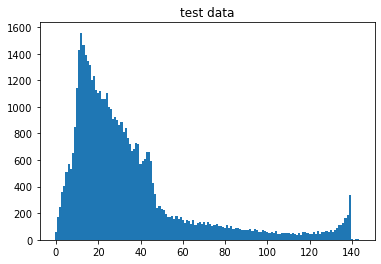

전체 문장 수: 49157
최단 문장 길이: 1
최장 문장 길이: 144
평균 문장 길이: 35


In [ ]:
draw_sentence_length(test_data["document"], title = "test data")

### **2-2-3. 최적의 max_len 탐색 함수**

In [ ]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

### **2-2-4. train_data 최적의 max_len 확인**

In [ ]:
below_threshold_len(110, train_data["document"])
below_threshold_len(100, train_data["document"]) 
below_threshold_len(10, train_data["document"])
below_threshold_len(8, train_data["document"])

전체 샘플 중 길이가 110 이하인 샘플의 비율: 95.21965768699293
전체 샘플 중 길이가 100 이하인 샘플의 비율: 94.0594601250496
전체 샘플 중 길이가 10 이하인 샘플의 비율: 8.543459523060294
전체 샘플 중 길이가 8 이하인 샘플의 비율: 5.559508010562176


### **2-2-5. test_data 최적의 max_len 확인**

In [ ]:
below_threshold_len(110, test_data["document"])
below_threshold_len(100, test_data["document"]) 
below_threshold_len(10, test_data["document"])
below_threshold_len(8, test_data["document"])

전체 샘플 중 길이가 110 이하인 샘플의 비율: 95.18278169945278
전체 샘플 중 길이가 100 이하인 샘플의 비율: 94.10663791525113
전체 샘플 중 길이가 10 이하인 샘플의 비율: 8.871574750289888
전체 샘플 중 길이가 8 이하인 샘플의 비율: 5.820127347071628


### **2-2-6. train_data, test_data 데이터 분포 길이 조정 함수**

In [ ]:
def filt_length(data, min_len, max_len):
    df = train_data.copy()
    df["length"] = df["document"].apply(lambda x: len(x))
    
    df = df.loc[df["length"] >= min_len]
    df = df.loc[df["length"] <= max_len]
    
    df.drop(["length"], axis = "columns", inplace=True)
    return df

### **2-2-7. train_data, test_data 데이터 분포 길이 조정**

**test_data와 train_data의 상위 5%, 하위 5% 정도를 제거한 범위인 8 - 110 범위의 데이터만 사용**

In [ ]:
min_len, max_len = 8, 110

train_data = filt_length(train_data, min_len = min_len, max_len = max_len)
test_data = filt_length(test_data, min_len = min_len, max_len = max_len)

y_train = np.array(train_data["label"])
y_test = np.array(test_data["label"])

### **2-2-8. 데이터 분포 조정 후 train_data 데이터 분포 길이 확인 및 시각화**

C:\Users\96452\AppData\Local\Temp\ipykernel_13424\324541869.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


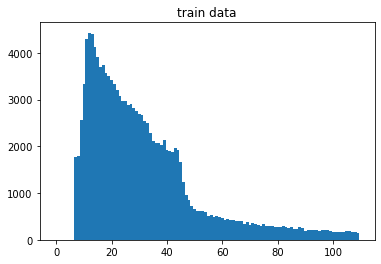

전체 문장 수: 132836
최단 문장 길이: 8
최장 문장 길이: 110
평균 문장 길이: 32


In [ ]:
draw_sentence_length(train_data["document"], title = "train data")

### **2-2-9. 데이터 분포 조정 후 test_data 데이터 분포 길이 확인 및 시각화**

C:\Users\96452\AppData\Local\Temp\ipykernel_13424\324541869.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


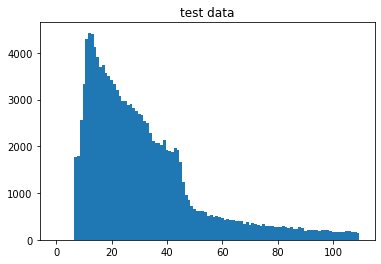

전체 문장 수: 132836
최단 문장 길이: 8
최장 문장 길이: 110
평균 문장 길이: 32


In [ ]:
draw_sentence_length(test_data["document"], title = "test data")

---

# **3. 토큰화**

## **3-1. 공백 기반 토큰화**

### **3-1-1. 공백 기반 토큰화 함수**

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

def get_split_tokenize(data):
    mecab_corpus = []
    
    for sentence in data:
        mecab_corpus.append(sentence.split())

    tokenizer.fit_on_texts(mecab_corpus)
    mecab_tensor = tokenizer.texts_to_sequences(mecab_corpus)
    mecab_tensor = tf.keras.preprocessing.sequence.pad_sequences(mecab_tensor, padding='post', maxlen=max_len)
    return mecab_tensor

### **3-1-2. 단어 크기 확인**

In [ ]:
X_train = get_split_tokenize(train_data["document"])
split_X_test = get_split_tokenize(test_data["document"])

print("단어 사전 크기:", len(tokenizer.word_index))

단어 사전 크기: 300566


### **3-1-3. 데이터 분할**

In [ ]:
split_train_input, split_val_input, split_train_target, split_val_target = \
    train_test_split(X_train, y_train, test_size=0.2, random_state=2525)

## **3-2. Okt을 활용한 형태소 기반 토큰화**

###  **3-2-1. Okt 토큰화 함수**

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
m = Okt()

def get_Okt_tokenize(data):
    Okt_corpus = []
    
    for sentence in data:
        Okt_corpus.append(m.morphs(sentence))

    tokenizer.fit_on_texts(Okt_corpus)
    Okt_tensor = tokenizer.texts_to_sequences(Okt_corpus)
    Okt_tensor = tf.keras.preprocessing.sequence.pad_sequences(Okt_tensor, padding ='post', maxlen = max_len)
    return Okt_tensor

### **3-2-2. 단어 사전 크기 확인**

In [ ]:
X_train = get_Okt_tokenize(train_data["document"])
Okt_X_test = get_Okt_tokenize(test_data["document"])

print("단어 사전 크기:", len(tokenizer.word_index))

단어 사전 크기: 91341


### **3-2-3. 데이터 분할**

In [ ]:
Okt_train_input, Okt_val_input, Okt_train_target, Okt_val_target = \
    train_test_split(X_train, y_train, test_size=0.2, random_state = 2525)

## **3-3. SentencePiece 기반 토큰화**

### **3-3-1. SentencePiece 학습 및 저장**

In [ ]:
temp_file = 'C:/Users/96452/00_work/NLP-02/data/korean-english-park.train.ko.temp'
vocab_size = 8000

with open(temp_file, 'w', encoding = 'utf-8') as f:
    for row in train_data['document']:
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_unigram --vocab_size={}'.format(temp_file, vocab_size)    
)

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_bep --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)    
)

### **3-3-2. SentencePiece 모델 테스트 함수**

In [ ]:
def test_performance(model):
    s = spm.SentencePieceProcessor()
    s.Load(model)

    # SentencePiece를 활용한 sentence -> encoding
    tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
    print(tokensIDs)

    # SentencePiece를 활용한 sentence -> encoded pieces
    print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

    # SentencePiece를 활용한 encoding -> sentence 복원
    print(s.DecodeIds(tokensIDs))

### **3-3-2. unigram 확인**

In [ ]:
unigram_vocab_list = pd.read_csv('kor_spm_unigram.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
unigram_vocab_list[:10]

,0,1
0,<unk>,0.00000
1,<s>,0.00000
2,</s>,0.00000
3,▁,-3.17945
4,.,-3.47926
5,..,-4.32507
6,이,-4.42715
7,▁영화,-4.50779
8,...,-4.56210
9,의,-4.71342


In [ ]:
test_performance(model = 'kor_spm_unigram.model')

[1441, 10, 398, 15, 1337, 10, 141, 17, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


### **3-3-3. bep 확인**

In [ ]:
bep_vocab_list = pd.read_csv('kor_spm_bep.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
bep_vocab_list[:10]

,0,1
0,<unk>,0
1,<s>,0
2,</s>,0
3,..,0
4,영화,-1
5,▁영화,-2
6,▁이,-3
7,...,-4
8,▁아,-5
9,▁재,-6


In [ ]:
test_performance(model = 'kor_spm_bep.model')

[5028, 888, 6556, 6294, 1450, 6290, 6396, 6284, 6282]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


### **3-3-4. SentencePiece 토큰화 함수**

In [ ]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("C:/Users/96452/00_work/NLP-02/kor_spm_bep.vocab".format(spm), 'r', encoding = 'utf-8') as f: 
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=max_len)

    return tensor, word_index, index_word

### **3-3-5. unigram 토큰화 및 데이터 분할**

In [ ]:
u = spm.SentencePieceProcessor()
u.Load('kor_spm_unigram.model') 

X_train, X_train_word_index, X_train_index_word = sp_tokenize(u, train_data['document'])
uni_X_test, X_test_word_index, X_test_index_word = sp_tokenize(u, test_data['document'])

uni_train_input, uni_val_input, uni_train_target, uni_val_target = \
    train_test_split(X_train, y_train, test_size=0.2, random_state = 2525)

### **3-3-6. bpe 토큰화 및 데이터 분할**

In [ ]:
b = spm.SentencePieceProcessor()
b.Load('kor_spm_bep.model') 

X_train, X_train_word_index, X_train_index_word = sp_tokenize(b, train_data['document'])
bpe_X_test, X_test_word_index, X_test_index_word = sp_tokenize(b, test_data['document'])

bpe_train_input, bpe_val_input, bpe_train_target, bpe_val_target = \
    train_test_split(X_train, y_train, test_size=0.2, random_state = 2525)

---

# **4. 모델 설계 및 학습**

## **4-1. 모델 설계**

In [ ]:
vocab_size = 8000
word_vector_dim = 128

In [ ]:
def get_model(vocab_size):
    model_1d = tf.keras.Sequential()
    model_1d.add(tf.keras.layers.Embedding(vocab_size, 16, input_shape=(None,)))
    model_1d.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
    model_1d.add(tf.keras.layers.MaxPooling1D(5))
    model_1d.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
    model_1d.add(tf.keras.layers.GlobalMaxPooling1D())
    model_1d.add(tf.keras.layers.Dense(8, activation='tanh'))
    model_1d.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
   
    model_1d.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model_1d.summary()
    print('\n')
    
    return model_1d

## **4-2. 모델 학습**

### **4-2-1. 공백 기반 토큰화 - 전체**

In [ ]:
early = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

split_model = get_model(300566)
split_model.fit(split_train_input, split_train_target, epochs = 30, validation_data = (split_val_input, split_val_target), callbacks = [early])

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, None, 16)          4809056   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_46 (Dense)             (None, 1)               

### **4-2-2. 공백 기반 토큰화 - 8000**

In [ ]:
early = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

split_cut_model = get_model(8000)
split_cut_model.fit(split_train_input, split_train_target, epochs = 30, validation_data = (split_val_input, split_val_target), callbacks = [early])

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, None, 16)          128000    
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 16)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_50 (Dense)             (None, 1)               

### **4-2-3. Okt를 활용한 형태소 기반 토큰화 - 전체**

In [ ]:
early = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

Okt_model = get_model(91341)
Okt_model.fit(Okt_train_input, Okt_train_target, epochs = 30, validation_data = (Okt_val_input, Okt_val_target), callbacks = [early])

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, None, 16)          1461456   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 16)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_48 (Dense)             (None, 1)               

### **4-2-4. Okt를 활용한 형태소 기반 토큰화 - 8000**

In [ ]:
early = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

Okt_cut_model = get_model(8000)
Okt_cut_model.fit(Okt_train_input, Okt_train_target, epochs = 30, validation_data = (Okt_val_input, Okt_val_target), callbacks = [early])

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, None, 16)          128000    
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 16)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_52 (Dense)             (None, 1)               

### **4-2-5. SentencePiece - unigram**

In [ ]:
early = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

uni_model = get_model(8000)
uni_model.fit(uni_train_input, uni_train_target, epochs = 30, validation_data = (uni_val_input, uni_val_target), callbacks = [early])

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, None, 16)          128000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_42 (Dense)             (None, 1)               

### **4-2-6. SentencePiece - bpe**

In [ ]:
early = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

bpe_model = get_model(8000)
bpe_model.fit(bpe_train_input, bpe_train_target, epochs = 30, validation_data = (bpe_val_input, bpe_val_target), callbacks = [early])

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, None, 16)          128000    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_44 (Dense)             (None, 1)               

---

# **5. 모델 평가**

## **5-1. 개별 모델 평가**

### **5-1-1. 공백 기반 토큰화 - 전체**

In [ ]:
split_model.evaluate(split_X_test, y_test)

4152/4152 [==============================] - 3s 788us/step - loss: 0.2095 - accuracy: 0.9539


[0.20954474806785583, 0.9538905024528503]

### **5-1-2. 공백 기반 토큰화 - 8000**

In [ ]:
split_cut_model.evaluate(split_X_test, y_test)

4152/4152 [==============================] - 4s 946us/step - loss: 0.3064 - accuracy: 0.8585


[0.30643796920776367, 0.858502209186554]

### **5-1-3. Okt를 활용한 형태소 기반 토큰화 - 전체**

In [ ]:
Okt_model.evaluate(Okt_X_test, y_test)

4152/4152 [==============================] - 4s 868us/step - loss: 0.1678 - accuracy: 0.9622


[0.16778375208377838, 0.9621939659118652]

### **5-1-4. Okt를 활용한 형태소 기반 토큰화 - 8000**

In [ ]:
Okt_cut_model.evaluate(Okt_X_test, y_test)

4152/4152 [==============================] - 4s 915us/step - loss: 0.1736 - accuracy: 0.9407


[0.1736217886209488, 0.9406937956809998]

### **5-1-5. SentencePiece - unigram**

In [ ]:
uni_model.evaluate(uni_X_test, y_test)

4152/4152 [==============================] - 4s 951us/step - loss: 0.2779 - accuracy: 0.8925


[0.2779094874858856, 0.8924990296363831]

### **5-1-6. SentencePiece - bpe**

In [ ]:
bpe_model.evaluate(bpe_X_test, y_test)

4152/4152 [==============================] - 4s 1ms/step - loss: 0.2703 - accuracy: 0.8947


[0.2703467011451721, 0.8947348594665527]

## **5-2. 전체 모델 비교 평가**

|**Tokenizer (Vocab Size)**|**Loss**|**Accuracy**|**평가 - 공백(8,000) 제외 전체적으로 Loss 0.2 / Accuracy 0.9 정도의 수치를 보임**|
:---:|:---:|:---:|:---:|
|**공백 (300,566)**|0.2095|0.9539|가장 사전 크기가 크고, 사전 크기가 큰 경우 생각보다 높은 정확도를 보임|
|**Okt (91,341)**|0.1678|0.9622|**비교 대상 중 가장 좋은 성능을 보임**|
|**공백 (8,000)**|0.3064|0.8585|**동일한 사전 크기로 비교하는 경우 가장 낮은 성능을 보임**|
|**Okt (8,000)**|0.1736|0.9407|동일한 사전 크기로 비교하는 경우에도 크게 Loss, Accuracy 값 차이 없이 좋은 성능을 보임|
|**unicode (8,000)**|0.2779|0.8925|실제 분리된 형태소를 살펴보면 bpe 보다 더 잘 분리하는 모습을 보이지만, 수치상으로는 크게 다르지 않거나 낮게 확인됨|
|**bpe (8,000)**|0.2703|0.8947|unicode와 거의 비슷한 성능을 보임|

---